In [1]:
from src.toy_functions import ResponseFunction, six_curve_sum
import torch
from ax import Client, RangeParameterConfig

from torch._tensor import Tensor
import importlib


from botorch.models import SingleTaskGP
import math
import importlib

from src import GPVisualiser, ax_helper
from botorch.models import SingleTaskGP
importlib.reload(GPVisualiser)


<module 'src.GPVisualiser' from 'c:\\GitHub\\BO-Coli\\src\\GPVisualiser.py'>

In [2]:
dim_names = ['x1', 'x2', 'x3', 'x4', 'x5', 'x6']
simple_func = lambda x: sum(torch.sqrt(x))
resp = ResponseFunction(simple_func, len(dim_names))
resp.evaluate(torch.tensor([1., 4., 9., 16., 25., 36.]))

tensor(21.)

In [3]:
from typing import Literal
import pandas as pd
import seaborn as sns


from src.ax_helper import get_guess_coords

# Sobol
The default initial parameter exploration strategy uses SOBOL algorithm:

### log param sobol:

[INFO 09-20 13:47:56] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-20 13:47:56] ax.api.client: Generated new trial 0 with parameters {'x0': 10.0, 'x1': 10.0, 'x2': 10.0, 'x3': 10.0, 'x4': 10.0, 'x5': 10.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-20 13:47:56] ax.api.client: Generated new trial 1 with parameters {'x0': 5.796229, 'x1': 56.685327, 'x2': 78.765249, 'x3': 1.357764, 'x4': 2.558368, 'x5': 2.176384} using GenerationNode Sobol.
[INFO 09-20 13:47:56] ax.api.client: Generated new trial 2 with parameters {'x

   trial_name         x0         x1         x2         x3         x4  \
0         0_0  10.000000  10.000000  10.000000  10.000000  10.000000   
1         1_0   5.796229  56.685327  78.765249   1.357764   2.558368   
2         2_0  67.639622   1.764922   2.797837  14.558901  65.948469   
3         3_0  13.962373  23.919828  17.030029   6.761751  14.312716   
4         4_0   1.579025   4.188074   4.703568  74.812581   4.145609   
5         5_0   3.019177  17.257199   1.097384  52.602173   6.326004   
6         6_0  26.666790   5.796746  41.139640   5.017253  28.597522   
7         7_0  40.897941  40.953596   6.736007  20.338298  32.410089   
8         8_0   3.500720   2.446286  18.273615   1.863201   1.707550   
9         9_0   4.808073  22.822979   7.947498   3.452652  75.625918   
10       10_0  52.921977   4.389350  27.726299  32.204061   2.231032   
11       11_0  19.252512  96.180082   1.657800   3.154555   4.841982   
12       12_0   2.350283   1.040187  48.327927  28.507707  12.25

<Axes: xlabel='x0', ylabel='x1'>

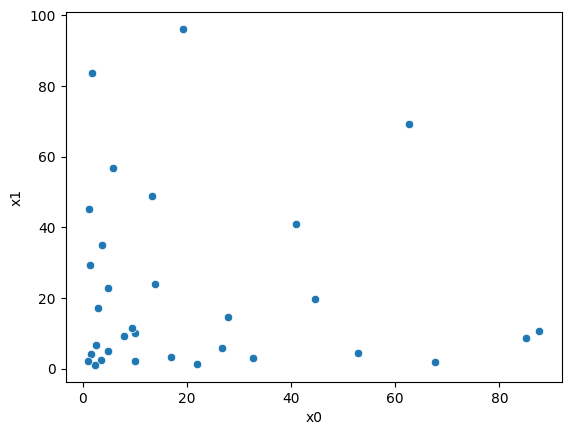

In [4]:
client = Client()

client.configure_experiment(
    name="batch_bo_test",
    parameters=[
        RangeParameterConfig(
            name=f"x{i}",
            bounds=(1, 100),
            parameter_type="float",
            scaling = 'log',
        ) for i in range(len(dim_names))
    ],
)


client.configure_optimization(objective="-loss")

client.get_next_trials(max_trials=32)

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x0", y="x1")

Low value oversampling is inline with logarithmic distribution.

**Considering that we expect overexpression to be optimal when compared to underexpression, Sobol should be run on a linear scale**.

### linear parameters sobol

[INFO 09-20 13:47:56] ax.api.client: GenerationStrategy(name='Center+Sobol+MBM:fast', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='MBM'), MinTrials(transition_to='MBM')]), GenerationNode(node_name='MBM', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])]) chosen based on user input and problem structure.
[INFO 09-20 13:47:56] ax.api.client: Generated new trial 0 with parameters {'x1': 50.5, 'x2': 50.5, 'x3': 50.5, 'x4': 50.5, 'x5': 50.5, 'x6': 50.5} using GenerationNode CenterOfSearchSpace.
[INFO 09-20 13:47:56] ax.api.client: Generated new trial 1 with parameters {'x1': 44.690792, 'x2': 57.369232, 'x3': 16.088656, 'x4': 61.676453, 'x5': 63.095143, 'x6': 86.064146} using GenerationNode Sobol.
[INFO 09-20 13:47:56] ax.api.client: Generated new trial 2 with parameters

  trial_name         x1         x2         x3         x4         x5         x6
0        0_0  50.500000  50.500000  50.500000  50.500000  50.500000  50.500000
1        1_0  44.690792  57.369232  16.088656  61.676453  63.095143  86.064146
2        2_0  53.970114  11.134627  70.372185   4.053854  31.599141  30.637791
3        3_0  79.673372  93.241788  39.522184  82.244764  23.294883  13.512085
4        4_0  20.896945  40.230162  96.897887  29.262788  83.793283  71.793134
5        5_0   9.925970  80.173412  59.883205  38.585058  99.659632  94.776064
6        6_0  93.461287  28.572706   5.697843  97.757555   7.451993  40.120509
7        7_0  67.755122  70.606797  86.410396  19.466567  40.508514   4.797496
8        8_0  33.722699  22.671234  29.129885  70.904689  54.210736  62.302458
9        9_0  29.015470  96.826964  80.686427  91.124967  36.394749  65.262326


<Axes: xlabel='x1', ylabel='x2'>

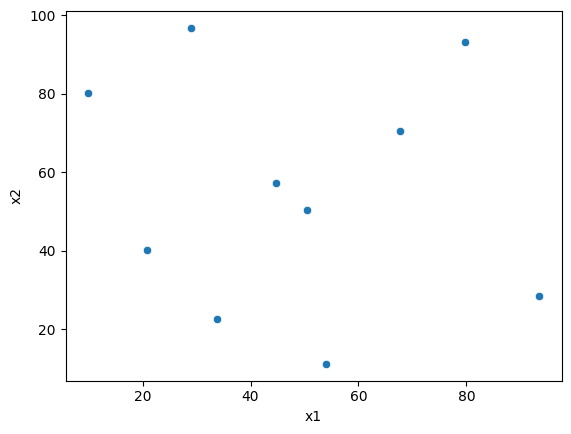

In [5]:


client = Client()

parameters=[
    RangeParameterConfig(
        name=dim,
        bounds=(1, 100),
        parameter_type="float",
        # scaling = 'log',
    ) for dim in dim_names
]


client.configure_experiment(
    name="batch_bo_test",
    parameters=parameters
)


client.configure_optimization(objective="response")

client.get_next_trials(max_trials=10)




for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):
        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})

coords = get_guess_coords(client)
print(coords)
sns.scatterplot(data=coords, x="x1", y="x2")

A nice and informative initial guess grid is formed

[INFO 09-20 13:47:57] ax.api.client: Generated new trial 10 with parameters {'x1': 1.0, 'x2': 93.367893, 'x3': 100.0, 'x4': 82.869803, 'x5': 100.0, 'x6': 59.823879} using GenerationNode MBM.
[WARNING 09-20 13:47:57] ax.api.client: 6 trials requested but only 1 could be generated.
C:\Users\326po\AppData\Local\Temp\ipykernel_25840\767171169.py:19: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



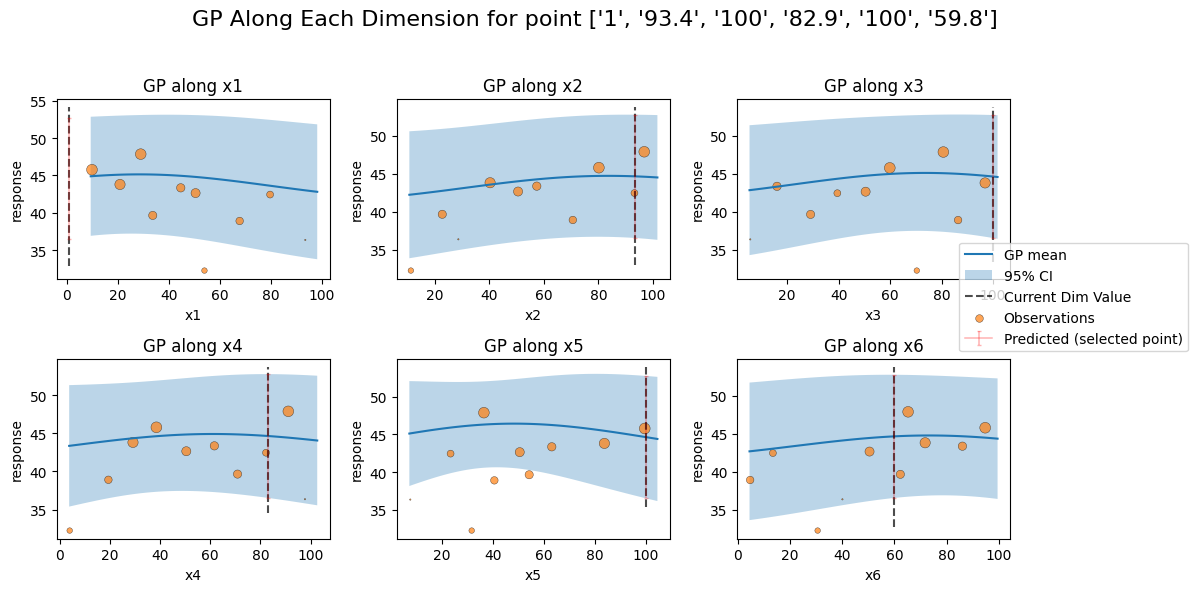

In [6]:


for i, trial in ax_helper.get_obs_from_client(client, response_col='response').iterrows():
    if not pd.isna(trial['response']):
        continue

    response = resp.evaluate(trial[dim_names])
    client.complete_trial(trial_index=i, raw_data={"response": float(response)})

client.get_next_trials(max_trials=6)

obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)


for i, trial in obs.iterrows():
    if pd.isna(trial['response']):

        coords = trial.loc[dim_names]

        plotter.plot_all(torch.tensor(coords))




(<Figure size 1200x600 with 6 Axes>,
 array([<Axes: title={'center': 'GP along x1'}, xlabel='x1', ylabel='response'>,
        <Axes: title={'center': 'GP along x2'}, xlabel='x2', ylabel='response'>,
        <Axes: title={'center': 'GP along x3'}, xlabel='x3', ylabel='response'>,
        <Axes: title={'center': 'GP along x4'}, xlabel='x4', ylabel='response'>,
        <Axes: title={'center': 'GP along x5'}, xlabel='x5', ylabel='response'>,
        <Axes: title={'center': 'GP along x6'}, xlabel='x6', ylabel='response'>],
       dtype=object))

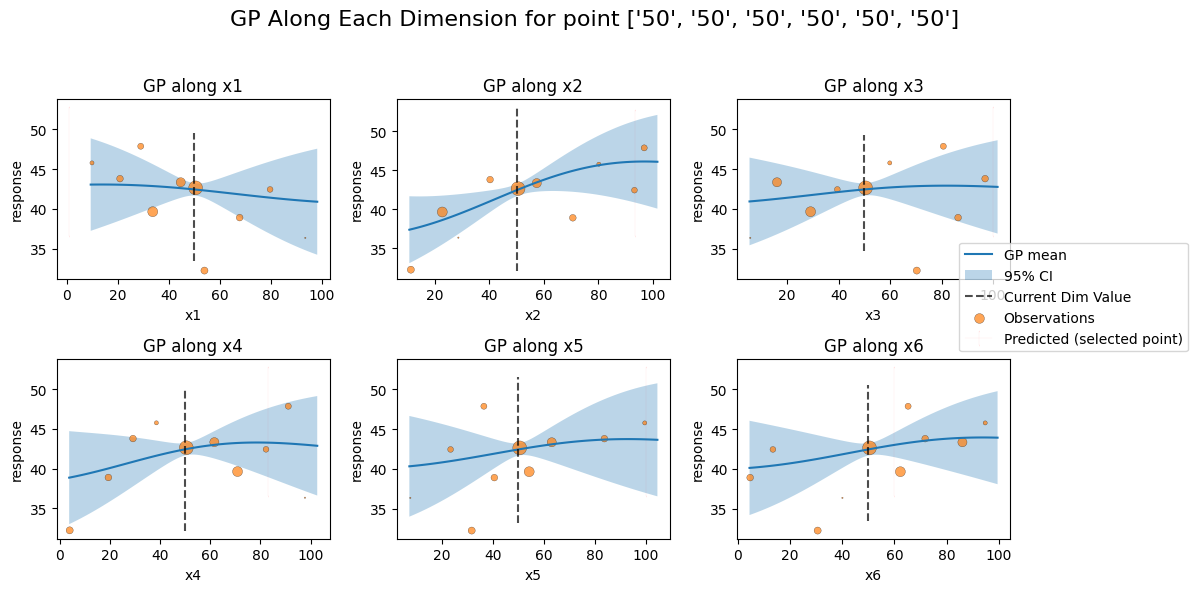

In [7]:
obs = ax_helper.get_obs_from_client(client, response_col='response')
plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, dim_names, 'response', parameters)
plotter.plot_all([50,50,50,50,50,50])

In [8]:
obs

,trial_name,x1,x2,x3,x4,x5,x6,response
0,0_0,50.500000,50.500000,50.500000,50.500000,50.500000,50.500000,42.638011
1,1_0,44.690792,57.369232,16.088656,61.676453,63.095143,86.064146,43.344189
2,2_0,53.970114,11.134627,70.372185,4.053854,31.599141,30.637791,32.241979
3,3_0,79.673372,93.241788,39.522184,82.244764,23.294883,13.512085,42.440086
4,4_0,20.896945,40.230162,96.897887,29.262788,83.793283,71.793134,43.794174
5,5_0,9.925970,80.173412,59.883205,38.585058,99.659632,94.776064,45.772890
6,6_0,93.461287,28.572706,5.697843,97.757555,7.451993,40.120509,36.351049
7,7_0,67.755122,70.606797,86.410396,19.466567,40.508514,4.797496,38.896896
8,8_0,33.722699,22.671234,29.129885,70.904689,54.210736,62.302458,39.642245
9,9_0,29.015470,96.826964,80.686427,91.124967,36.394749,65.262326,47.866489


# Custom Botorch model

break

<Axes: >

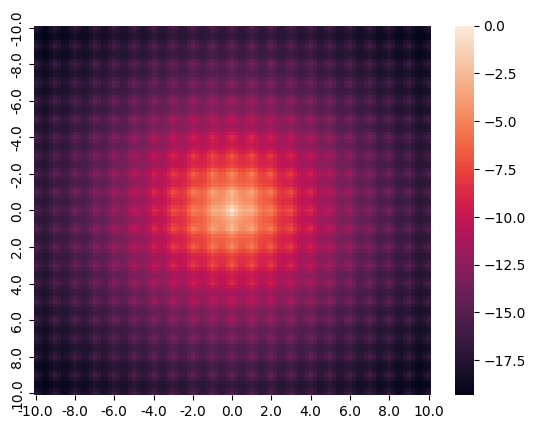

In [9]:
range_parameters = [
    RangeParameterConfig(
        name="x1", parameter_type="float", bounds=(-10, 10)
    ),
    RangeParameterConfig(
        name="x2", parameter_type="float", bounds=(-10, 10)
    )
]


def test_function(x1, x2):
    # Ackley function (commonly used for optimization benchmarks)
    a = 20
    b = 0.2
    c = 2 * math.pi
    sum_sq = 0.5 * (x1**2 + x2**2)
    cos_comp = 0.5 * (math.cos(c * x1) + math.cos(c * x2))
    ackley_grid = -a * math.exp(-b * math.sqrt(sum_sq)) - math.exp(cos_comp) + a + math.exp(1)
    return -ackley_grid


import numpy as np
grid = np.linspace(-10, 10, 101)
x1_grid, x2_grid = np.meshgrid(grid, grid)
ackley_vals = np.array([test_function(x1, x2) for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())]).reshape(x1_grid.shape)
sns.heatmap(
    pd.DataFrame(ackley_vals, index=np.round(grid, 2), columns=np.round(grid, 2)),
    xticklabels=10,
    yticklabels=10
)


In [10]:
from ax.benchmark.problems import surrogate
from ax.generation_strategy.center_generation_node import CenterGenerationNode
from ax.generation_strategy.transition_criterion import MinTrials
from ax.generation_strategy.generation_strategy import GenerationStrategy
from ax.generation_strategy.generation_node import GenerationNode
from ax.generation_strategy.generator_spec import GeneratorSpec
from ax.adapter.registry import Generators
import numpy as np
from ax.api.client import Client
from ax.api.configs import RangeParameterConfig

def construct_generation_strategy(
    generator_spec: GeneratorSpec, node_name: str, transition_trials: int=5
) -> GenerationStrategy:
    """Constructs a Center + Sobol + Modular BoTorch `GenerationStrategy`
    using the provided `generator_spec` for the Modular BoTorch node.
    """
    botorch_node = GenerationNode(
        node_name=node_name,
        generator_specs=[generator_spec],
    )
    sobol_node = GenerationNode(
        node_name="Sobol",
        generator_specs=[
            GeneratorSpec(
                generator_enum=Generators.SOBOL,
            ),
        ],
        transition_criteria=[
            # Transition to BoTorch node once there are `transition_trials` trials on the experiment.
            MinTrials(
                threshold=transition_trials,
                transition_to=botorch_node.node_name,
                use_all_trials_in_exp=True,
            )
        ]
    )
    # Center node is a customized node that uses a simplified logic and has a
    # built-in transition criteria that transitions after generating once.
    center_node = CenterGenerationNode(next_node_name=sobol_node.node_name)
    return GenerationStrategy(
        name=f"Center+Sobol+{node_name}",
        nodes=[center_node, sobol_node, botorch_node]
    )


### Define the GP surrogate


MES (max value entropy search) should be the ideal choice for acquisition functions because:
* It can handle noise.
* Samples in a manner to best define the optimum.
    * Consequently, will rarely repeat exactly identical samplings.
* Has a cost/fidelity setting

In [11]:

from botorch.models import SingleTaskGP
from botorch.acquisition import qLogExpectedImprovement, qMaxValueEntropy

from gpytorch.kernels import MaternKernel
from botorch.models import SingleTaskGP
from ax.generators.torch.botorch_modular.surrogate import SurrogateSpec, ModelConfig

surrogate_spec = SurrogateSpec(
    model_configs=[
        ModelConfig(
            botorch_model_class=SingleTaskGP,
        ),
    ]
)

generator_spec = GeneratorSpec(
    generator_enum=Generators.BOTORCH_MODULAR,
    model_kwargs={
        "surrogate_spec": surrogate_spec,
        "botorch_acqf_class": qLogExpectedImprovement,
        # Can be used for additional inputs that are not constructed
        # by default in Ax. We will demonstrate below.
        "acquisition_options": {},
    },
    # We can specify various options for the optimizer here.
    model_gen_kwargs = {
        "model_gen_options": {
            "optimizer_kwargs": {
                "num_restarts": 20,
                "sequential": False,
                "options": {
                    "batch_limit": 5,
                    "maxiter": 200,
                },
            },
        },
    }
)


generation_strategy = construct_generation_strategy(
    generator_spec=generator_spec,
    node_name="Single task, LogEI",
)

generation_strategy

GenerationStrategy(name='Center+Sobol+Single task, LogEI', nodes=[CenterGenerationNode(next_node_name='Sobol'), GenerationNode(node_name='Sobol', generator_specs=[GeneratorSpec(generator_enum=Sobol, model_key_override=None)], transition_criteria=[MinTrials(transition_to='Single task, LogEI')]), GenerationNode(node_name='Single task, LogEI', generator_specs=[GeneratorSpec(generator_enum=BoTorch, model_key_override=None)], transition_criteria=[])])

Generat

In [12]:
client = Client()


client.configure_experiment(parameters=range_parameters)

metric_name = "response"

client.set_generation_strategy(
    generation_strategy=generation_strategy,
)

client.configure_optimization(objective=metric_name)


[INFO 09-20 13:47:58] ax.api.client: Generated new trial 0 with parameters {'x1': 0.0, 'x2': 0.0} using GenerationNode CenterOfSearchSpace.
[INFO 09-20 13:47:58] ax.api.client: Generated new trial 1 with parameters {'x1': 3.458322, 'x2': -5.284177} using GenerationNode Sobol.
[INFO 09-20 13:47:58] ax.api.client: Generated new trial 2 with parameters {'x1': -2.523031, 'x2': 1.311565} using GenerationNode Sobol.
[INFO 09-20 13:47:58] ax.api.client: Generated new trial 3 with parameters {'x1': -8.930422, 'x2': -3.515125} using GenerationNode Sobol.
[INFO 09-20 13:47:58] ax.api.client: Generated new trial 4 with parameters {'x1': 9.863426, 'x2': 9.96729} using GenerationNode Sobol.
[INFO 09-20 13:47:58] ax.api.client: Trial 0 marked COMPLETED.
[INFO 09-20 13:47:58] ax.api.client: Trial 1 marked COMPLETED.
[INFO 09-20 13:47:58] ax.api.client: Trial 2 marked COMPLETED.
[INFO 09-20 13:47:58] ax.api.client: Trial 3 marked COMPLETED.
[INFO 09-20 13:47:58] ax.api.client: Trial 4 marked COMPLETED

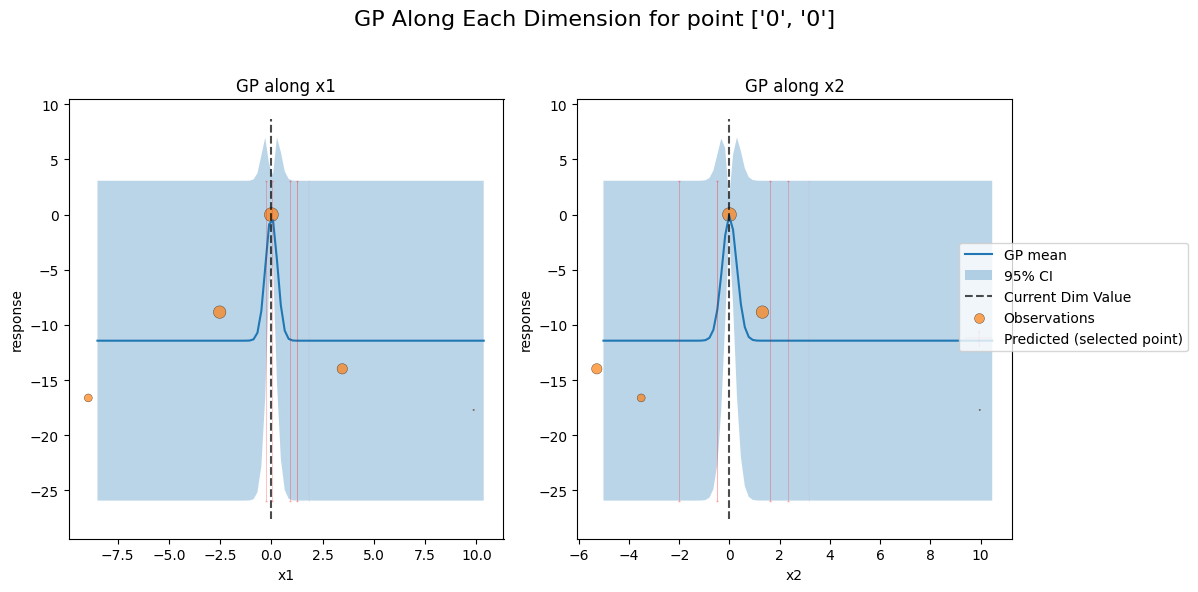

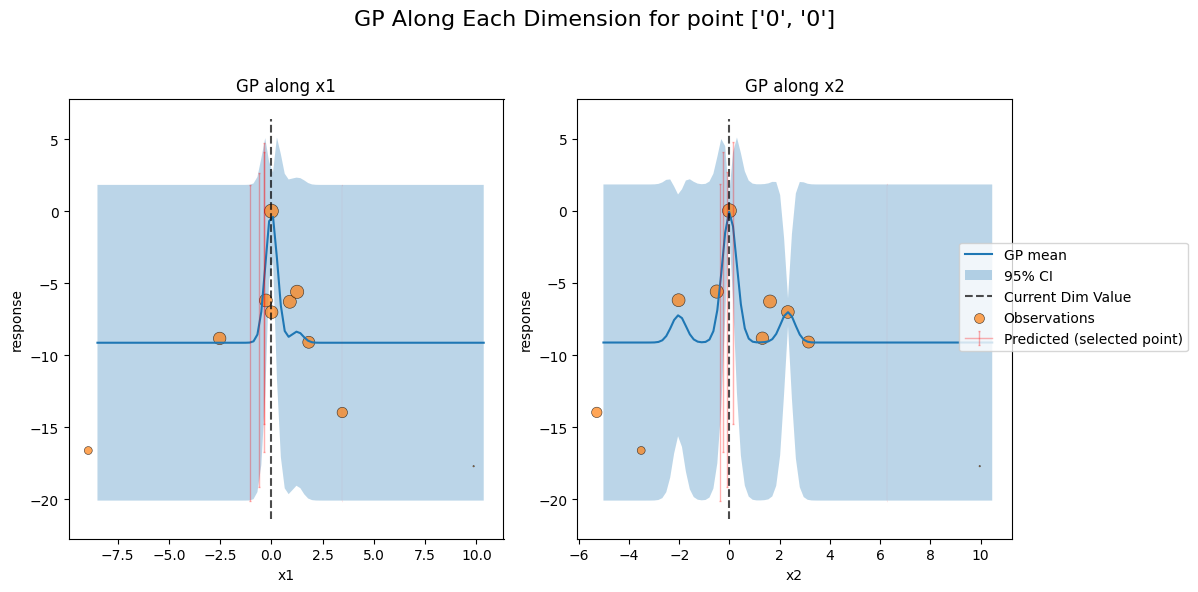

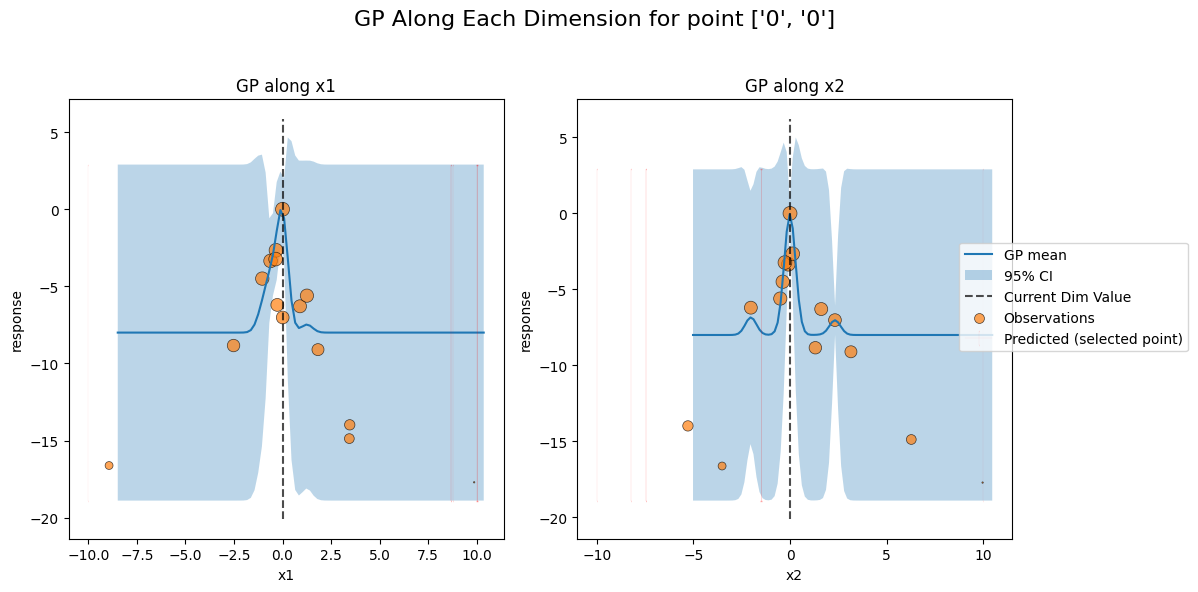

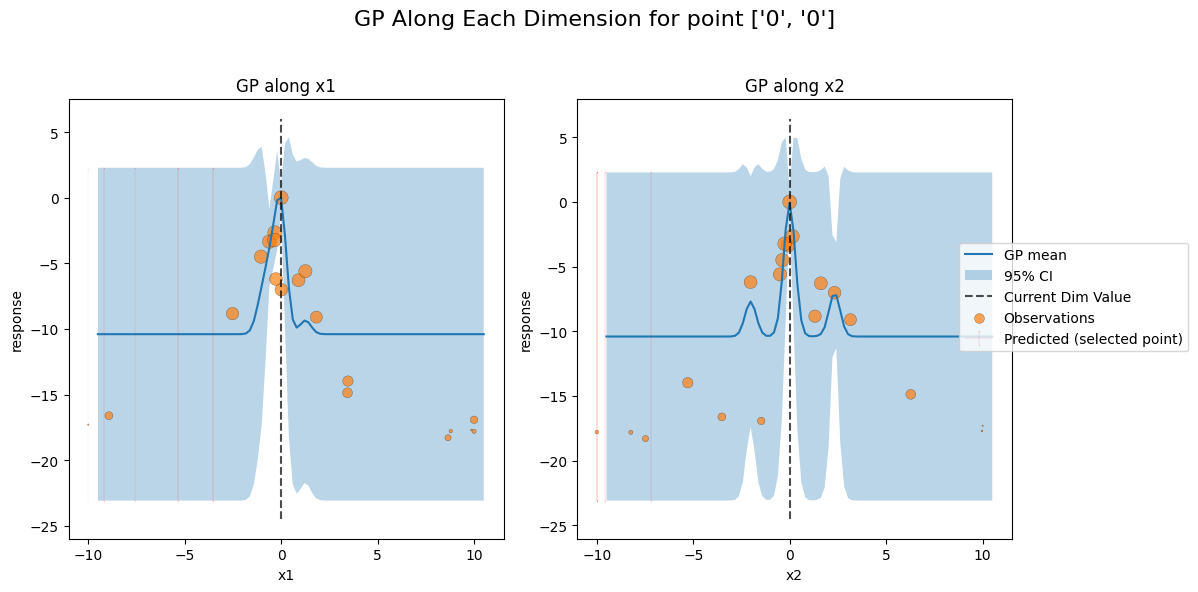

In [13]:
for _ in range(5):
    trials = client.get_next_trials(max_trials=5)

    
    obs = ax_helper.get_obs_from_client(client, response_col=metric_name)
    if not all(obs[metric_name].isna()):
        best = obs.loc[obs[metric_name].idxmax()]


        plotter = GPVisualiser.GPVisualiserMatplotlib(SingleTaskGP, obs, ["x1", "x2"], metric_name)
        plotter.plot_all(best[["x1", "x2"]].to_list())

    for index, parameters in trials.items():
        result = test_function(**parameters)
        client.complete_trial(trial_index=index, raw_data={metric_name: result})



In [14]:
obs

,trial_name,x1,x2,response
0,0_0,0.000000,0.000000,-4.440892e-16
1,1_0,3.458322,-5.284177,-1.397609e+01
2,2_0,-2.523031,1.311565,-8.835662e+00
3,3_0,-8.930422,-3.515125,-1.661479e+01
4,4_0,9.863426,9.967290,-1.770308e+01
5,5_0,0.898774,1.615190,-6.290948e+00
6,6_0,-0.269769,-2.026508,-6.200827e+00
7,7_0,1.254857,-0.504113,-5.602287e+00
8,8_0,0.007896,2.326365,-7.017315e+00
9,9_0,1.823738,3.152405,-9.101541e+00
